In [116]:
import matplotlib.pyplot as plt
%matplotlib inline
from myshow import myshow
import numpy as np

In [117]:
# OpenCV
# source: https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/
import cv2

def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=3)
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad


# Read 8-bit color image.
# This is an image in which the three channels are concatenated vertically.
im_color = cv2.imread("images/locomotive.jpg", cv2.IMREAD_COLOR);
im_color = im_color[200:800, 200:800, :]
im = cv2.imread("images/locomotive.jpg", cv2.IMREAD_GRAYSCALE);
im = im[200:800, 200:800]
# Find the width and height of the color image
height, width = im.shape
 
# Allocate space for aligned image
im_aligned = np.zeros((height, width, 3), dtype=np.uint8)
 
# The blue and green channels will be aligned to the red channel.
im_aligned[:, :, 2] = im_color[:, :, 2]
 

<a href="http://docs.opencv.org/master/dc/d6b/group__video__track.html#ga8d00a609cfb78d81b39ecd57f023fa6c">OpenCV Motion models</a>

In [153]:
# Define motion model
warp_mode = cv2.MOTION_TRANSLATION  #  HOMOGRAPHY
 
# Set the warp matrix to identity.
if warp_mode == cv2.MOTION_HOMOGRAPHY:
   warp_matrix = np.eye(3, 3, dtype=np.float32)
else:
   warp_matrix = np.eye(2, 3, dtype=np.float32)
 
# Set the stopping criteria for the algorithm.
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 500, 1e-12)

# Warp the blue and green channels to the red channel
for i in xrange(0, 2):
    (cc, warp_matrix) = cv2.findTransformECC(get_gradient(im_color[:, :, 2]), 
                                             get_gradient(im_color[:, :, i]),
                                             warp_matrix, 
                                             warp_mode, 
                                             criteria)
    warp_matrix[:,2] *= 37.  # magic
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        # Use Perspective warp when the transformation is a Homography
        im_aligned[:, :, i] = cv2.warpPerspective(im_color[:, :, i],
                                                  warp_matrix, 
                                                  (width, height), 
                                                  flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else:
        # Use Affine warp when the transformation is not a Homography
        im_aligned[:, :, i] = cv2.warpAffine(im_color[:, :, i], 
                                             warp_matrix, 
                                             (width, height), 
                                             flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    print warp_matrix

[[  1.           0.          -2.6860075 ]
 [  0.           1.          18.84903336]]
[[ 1.          0.          1.55030525]
 [ 0.          1.          4.1228447 ]]


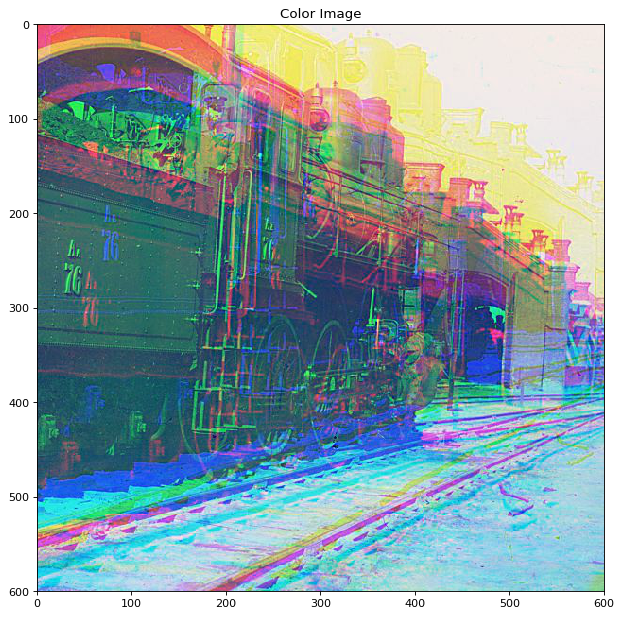

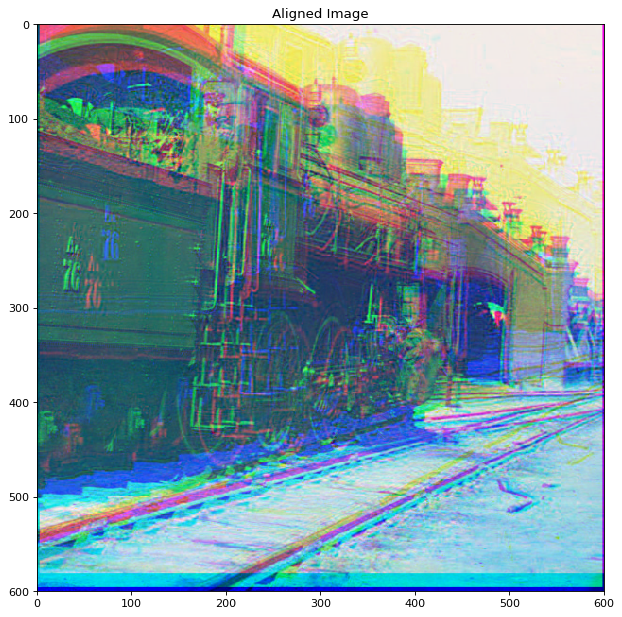

In [154]:
# Show final output
myshow(im_color, title="Color Image")
myshow(im_aligned, title="Aligned Image")

In [155]:
import SimpleITK as sitk

img = sitk.ReadImage("images/locomotive.jpg", sitk.sitkVectorUInt8)
output = sitk.GetImageFromArray(np.empty((600, 600, 3)), sitk.sitkUInt8)
fixed_image = sitk.VectorIndexSelectionCast(img, 0)[200:800, 200:800]  # red

In [156]:
registration_method = sitk.ImageRegistrationMethod()
# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.05)
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                  numberOfIterations=100, 
                                                  convergenceMinimumValue=1e-12, 
                                                  convergenceWindowSize=10,
                                                  estimateLearningRate=registration_method.EachIteration)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False);

In [157]:
images = [fixed_image]
for i in range(1, 3):
    moving_image = sitk.VectorIndexSelectionCast(img, i)[200:800, 200:800] # green or blue
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                          moving_image, 
                                                          sitk.Euler2DTransform(), 
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)

    moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, 
                                     sitk.sitkLinear,
                                     0.0, moving_image.GetPixelID())
    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                  sitk.Cast(moving_image, sitk.sitkFloat32))
    
    images.append(sitk.Resample(moving_image, fixed_image, final_transform, 
                                sitk.sitkLinear, 0.0, moving_image.GetPixelID()))

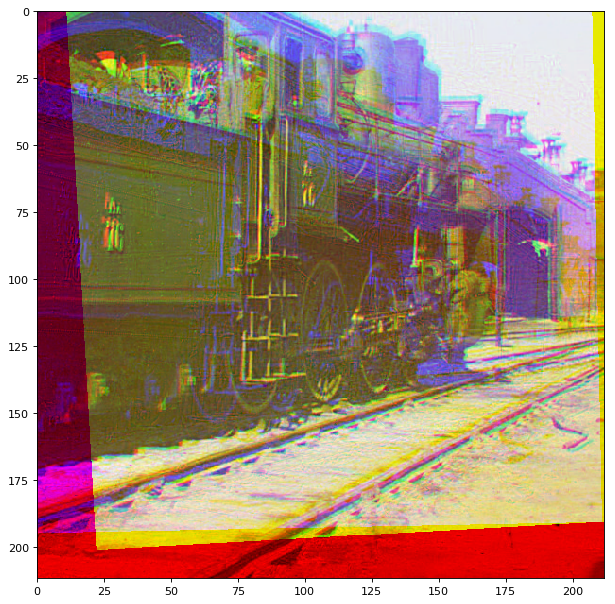

In [158]:
# myshow(fixed_image)
myshow(sitk.Compose(images))

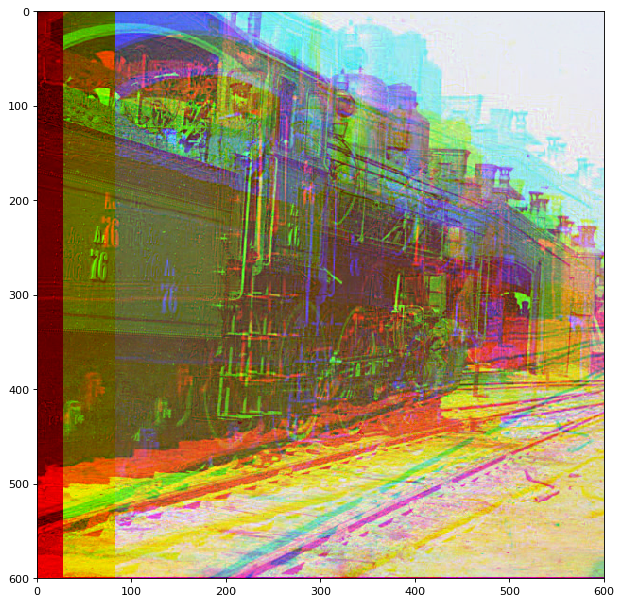

In [159]:
# scikit-image
from skimage.feature import register_translation
from skimage.transform import warp, EuclideanTransform
import skimage.io as skio

img = skio.imread('images/locomotive.jpg')
fixed = img[200:800, 200:800, 0]
output = np.empty(list(fixed.shape) + [3], dtype=fixed.dtype)
output[:,:,0] = fixed
for i in range(1, 3):
    moving = np.asarray(img[200:800, 200:800, i], dtype=np.float) # What happens if you don't cast to float?
    shifts, err, phasediff = register_translation(fixed, moving, space='real')
    output[:,:,i] = warp(moving, EuclideanTransform(translation=shifts))
myshow(output)